# Cracks detection

Firstly, we shall import all the necessary packages.

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras import Input
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout, BatchNormalization, Dense, Flatten

Now, let's check whether the train dataset is balanced.

In [2]:
num_anomaly = len(os.listdir("train/anomaly"))
num_normal  = len(os.listdir("train/normal"))

print(f"There are {num_anomaly} photos with anomalies and {num_normal} without them")

There are 455 photos with anomalies and 14545 without them


As we may see, the training dataset is strongly unbalanced. That's why we are not going to use all the given data, but rather two balanced classes. For that purpose, we will take all the data from the smaller class, which is 455 photos, and three times more of the bigger class, which is 455*3=1365 randomly taken photos. That gives us 1820 photos in the training dataset.

In [3]:
X, Y = [], []
for f in os.listdir("train/anomaly"):
    img = cv2.imread(f"train/anomaly/{f}")
    X.append(img)
    Y.append(1)

normal_full = os.listdir("train/normal")
indices = np.random.choice(len(normal_full), size=num_anomaly*3)
normal_sample = [normal_full[i] for i in indices]

for f in normal_sample:
    img = cv2.imread(f"train/normal/{f}")
    X.append(img)
    Y.append(0)  
Y = to_categorical(Y)

X, Y = np.array(X), np.array(Y)

Here we are going to set general hyperparameters.

In [4]:
IMG_ROWS, IMG_COLS = 227, 227
BATCH_SIZE = 32
NUM_EPOCHS = 10

And finally, build our computer vision model.

In [5]:
def build_lenet():
    model = Sequential()

    model.add(Input(shape=(IMG_ROWS, IMG_COLS, 3)))
    model.add(Conv2D(6, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2,2)))
    
    model.add(Flatten()) 
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(2, activation = 'softmax'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'precision', 'recall', 'f1_score'])
    return model

It is easy to see that we chose the LeNet architecture and recreated it from scratch, layer by layer. We did so, because the problem we are solving is a simple binary classification with rather small images, so a simple architecture like this one may prove effective.

Now, we will train our model on the previously collected data.

In [6]:
lenet = build_lenet()
lenet.fit(X, Y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_split=0.25, shuffle=True)
lenet.save("lenet.keras")

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.6311 - f1_score: 0.4854 - loss: 109.6480 - precision: 0.6311 - recall: 0.6311 - val_accuracy: 0.9758 - val_f1_score: 0.4939 - val_loss: 0.2561 - val_precision: 0.9758 - val_recall: 0.9758
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9672 - f1_score: 0.9619 - loss: 0.1624 - precision: 0.9672 - recall: 0.9672 - val_accuracy: 0.9934 - val_f1_score: 0.4983 - val_loss: 0.1143 - val_precision: 0.9934 - val_recall: 0.9934
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9789 - f1_score: 0.9770 - loss: 0.0964 - precision: 0.9789 - recall: 0.9789 - val_accuracy: 0.9956 - val_f1_score: 0.4989 - val_loss: 0.0265 - val_precision: 0.9956 - val_recall: 0.9956
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9878 - f1_score: 0.9861 - loss: 0.0424 - precision: 0.9878 - recall: 0.9878 - val_accuracy: 0.9956 - val_f1_score: 0.4989 - val_loss: 0.0561 - val_precision: 0.9956 - val_recall: 0

Here are functions to load test data and visualize predicted results, which we will use later.

In [7]:
def load_test_data(path):
    X, Y = [], []
    for f in os.listdir(f"{path}/anomaly"):
        img = cv2.imread(f"{path}/anomaly/{f}")
        X.append(img)
        Y.append(1)
    
    for f in os.listdir(f"{path}/normal"):
        img = cv2.imread(f"{path}/normal/{f}")
        X.append(img)
        Y.append(0)  
    Y = to_categorical(Y)
    
    X, Y = np.array(X), np.array(Y)
    return X, Y

In [8]:
def visualize_result(actual, predicted):
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["normal", "anomaly"])
    cm_display.plot()
    plt.show()

    accuracy = metrics.accuracy_score(actual, predicted)
    precision = metrics.precision_score(actual, predicted)
    recall = metrics.recall_score(actual, predicted)
    f1 = metrics.f1_score(actual, predicted)

    print(f"Accuracy:  {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall:    {recall}")
    print(f"F1 score:  {f1}")

Let's first use the balanced validation dataset to understand whether our model is working properly in general.

In [9]:
X_valid, Y_valid = load_test_data("valid_balanced")
if 'lenet' in globals():
    Y_predicted = lenet.predict(X_valid)
elif "lenet.keras" in os.listdir():
    lenet = load_model("lenet.keras")
    Y_predicted = lenet.predict(X_valid)
else:
    print("Ther is no model neither trained nor loaded")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


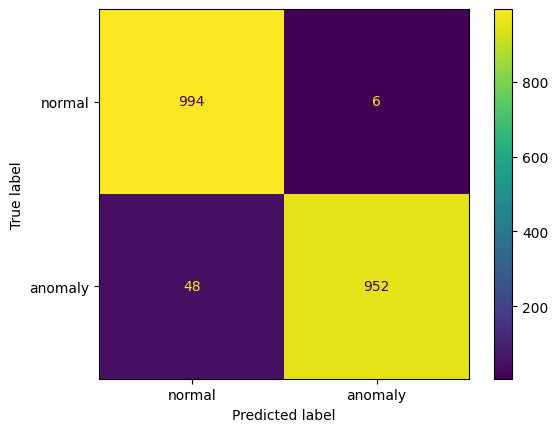

Accuracy:  0.973
Precision: 0.9937369519832986
Recall:    0.952
F1 score:  0.9724208375893769


In [10]:
if "Y_predicted" in globals():
    visualize_result(np.argmax(Y_valid, axis = 1), np.argmax(Y_predicted, axis = 1))

As we may see, our model is showing very good results. Most images are classified correctly, and all the metrics are higher than 95%, with an F1 score of 97.2%.

Now, let's repeat this process with the unbalanced dataset.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


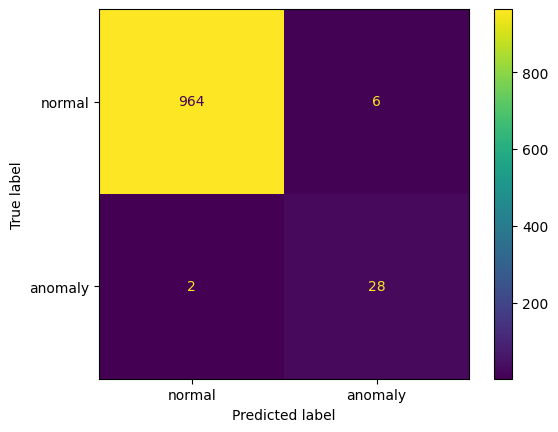

Accuracy:  0.992
Precision: 0.8235294117647058
Recall:    0.9333333333333333
F1 score:  0.875


In [11]:
X_valid, Y_valid = load_test_data("valid_unbalanced")
if 'lenet' in globals():
    Y_predicted = lenet.predict(X_valid)
elif "lenet.keras" in os.listdir():
    lenet = load_model("lenet.keras")
    Y_predicted = lenet.predict(X_valid)
else:
    print("Ther is no model neither trained nor loaded")
if "Y_predicted" in globals():
    visualize_result(np.argmax(Y_valid, axis = 1), np.argmax(Y_predicted, axis = 1))

As we can see from the confusion matrix, our model remains a good classifier. It categorized only two images of cracks as normal, while six normal images were labeled as defective. The F1 score is now significantly lower, at 87.5%. This situation arises from a considerable difference in the image quantities: every type I mistake is crucial for counting metrics. Nevertheless, the model's performance is still very high.